In [1]:
# Essential libraries for data handling, visualization, and modeling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# DBSCAN and data generation
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# For evaluation
from sklearn.metrics import silhouette_score

import warnings 
warnings.simplefilter('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
# Generate a synthetic "moons" dataset, well-suited for DBSCAN
X, y = make_moons(
    n_samples=500, noise=0.07, random_state=27
)

# Create a DataFrame for consistency
df = pd.DataFrame(
    X, columns=['feature_1', 'feature_2']
)
df['true_label'] = y

# Preview the data
df.head()

,feature_1,feature_2,true_label
0,0.935680,0.408027,0
1,1.935616,0.425880,1
2,1.495578,-0.310207,1
3,1.024910,0.270916,0
4,1.491663,-0.197706,1


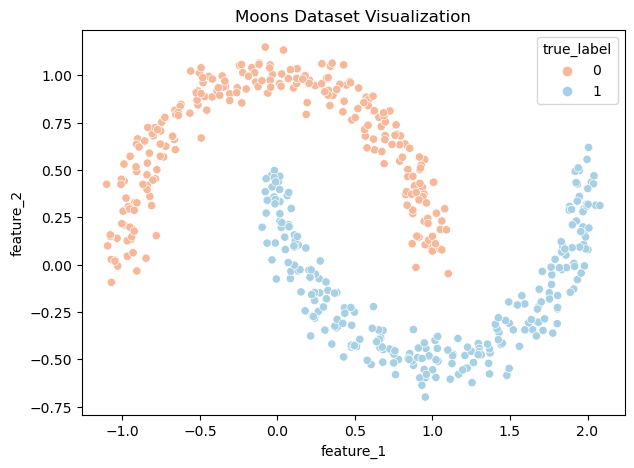

In [4]:
# Visualize the raw data and true labels
plt.figure(figsize=(7, 5))
sns.scatterplot(
    x='feature_1'
    , y='feature_2'
    , hue='true_label'
    , palette='RdBu'
    , data=df
)
plt.title('Moons Dataset Visualization')
plt.show();

,feature_1,feature_2,true_label
0,0.935680,0.408027,0
1,1.935616,0.425880,1
2,1.495578,-0.310207,1
3,1.024910,0.270916,0
4,1.491663,-0.197706,1
...,...,...,...
495,0.368494,-0.151010,1
496,0.960976,0.325571,0
497,0.421455,-0.310831,1
498,-0.773804,0.712314,0


In [10]:
# Scale features for DBSCAN (important for distance-based algorithms)
scaler = StandardScaler()

df[['feature_1', 'feature_2']] = scaler.fit_transform(
    df[['feature_1', 'feature_2']]
)
# scaled_X

In [9]:
# Check if features are correlated (not strictly needed for DBSCAN, but good practice)
corr_matrix = scaled_X.corr()
sns.heatmap(
    corr_matrix
    , annot=True
    , cmap='coolwarm'
)
plt.title('Feature Correlation Matrix')
plt.show();

AttributeError: 'numpy.ndarray' object has no attribute 'corr'